In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results
import coherent_modes_cpp as cm

In [2]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons =\
    get_from_config('sum_channel_to_photoelectrons')
meas_photons_per_electron =\
    get_from_config("Measured_photons_per_electron")
meas_photons_per_electron

0.008820875499988542

In [3]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_func = interp1d(bp_df["N"], bp_df['sz_um'],
                   bounds_error=False, fill_value="extrapolate")
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")

In [4]:
m0 = 10000
mfold = 8
seed = 1

In [5]:
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))

In [6]:
N0s = np.linspace(0.7e7, 2.25e7, 3)
df_to_save = pd.DataFrame({"N": np.concatenate([[0], N0s])})

In [7]:
EK_list = [[96.4,1.0],[95.4,1.0],[97.4,1.0],[96.4,0.97],[96.4,1.03]]

In [8]:
# for j,EK in enumerate(EK_list):
#     E_in, K_peak_in = EK
#     gamma_in = E_in/0.511
#     print(f"Working on EK {j+1} out of {len(EK_list)}")
#     wr_sim = generate_wr_sim_with_wigrad_results(
#     K_peak_in=K_peak_in,
#     gamma_in=gamma_in)
#     ampx3d = wr_sim.get_amplittude_3D(polarization='x')
#     mesh = get_from_config("radiation_mesh")
#     zobs = get_from_config("z_obs_m")
#     xmin, xmax, _ = mesh[0]
#     xmin = xmin/zobs
#     xmax = xmax/zobs
#     ymin, ymax, _ = mesh[1]
#     ymin = ymin/zobs
#     ymax = ymax/zobs
#     lmin, lmax, _ = mesh[2]
#     dax = (xmax-xmin)/(mesh[0][2]-1)
#     day = (ymax-ymin)/(mesh[1][2]-1)
#     dl = (lmax-lmin)/(mesh[2][2]-1)
#     sm =dax*day*dl*np.sum(np.absolute(ampx3d)**2)
#     Ms = np.zeros(N0s.shape)
#     for i,N0 in enumerate(N0s):
#         print(f"Working on {i+1} out of {len(N0s)}")
#         ex = ex_func(N0)
#         ey = ey_func(N0)
#         dpp = dpp_func(N0)
#         st = sz_func(N0)
#         # here ypu can adjust emittances to see how the result changes
#         adj = 1.0
#         Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#             lattice_df,adj*ex,adj*ey,dpp)
#         # Sx, Sy, dx, dy, sxp, syp = sx, sy, 0, 0, 0, 0
#         coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
#                                           st, sm, m0,mfold,seed],
#                                         dtype=np.float64)
#         Ms[i] = np.real(
#             cm.CalcMFromPrecalculatedFieldAmps(ampx3d,coh_modes_cpp_args)[-1])
#     df_to_save[f"{E_in},{K_peak_in}"] = np.concatenate([[0], N0s+N0s**2/Ms])
# df_to_save.to_csv("theor_NvarN.csv")

In [9]:
nvarn_df = pd.read_csv("theor_NvarN.csv", index_col=0)

In [10]:
nvarn_df

,N,"96.4,1.0","95.4,1.0","97.4,1.0","96.4,0.97","96.4,1.03"
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,7000000.0,2.775094e+07,3.020293e+07,2.526574e+07,2.546500e+07,2.988723e+07
2,14750000.0,8.398408e+07,9.254236e+07,7.552221e+07,7.619096e+07,9.146609e+07
3,22500000.0,1.576892e+08,1.747422e+08,1.410794e+08,1.423871e+08,1.726160e+08


In [11]:
Ns = nvarn_df['N']
varN0 = nvarn_df.iloc[:,1]
EerrT = nvarn_df.iloc[:,2]-varN0
EerrB = varN0-nvarn_df.iloc[:,3]
KerrT = nvarn_df.iloc[:,5]-varN0
KerrB = varN0-nvarn_df.iloc[:,4]
errT = np.sqrt(EerrT**2+KerrT**2)
errB = np.sqrt(EerrB**2+KerrB**2)
varNT = varN0+errT
varNB = varN0-errB
varN0func = interp1d(Ns, varN0,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
varNTfunc = interp1d(Ns, varNT,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
varNBfunc = interp1d(Ns, varNB,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")

In [12]:
x = np.linspace(0,2.25e7,50)
theor_df = pd.DataFrame({"N": x})
theor_df["varN"] = varN0func(x)
theor_df['varN_bottom'] = varNBfunc(x)
theor_df['varN_top'] = varNTfunc(x)

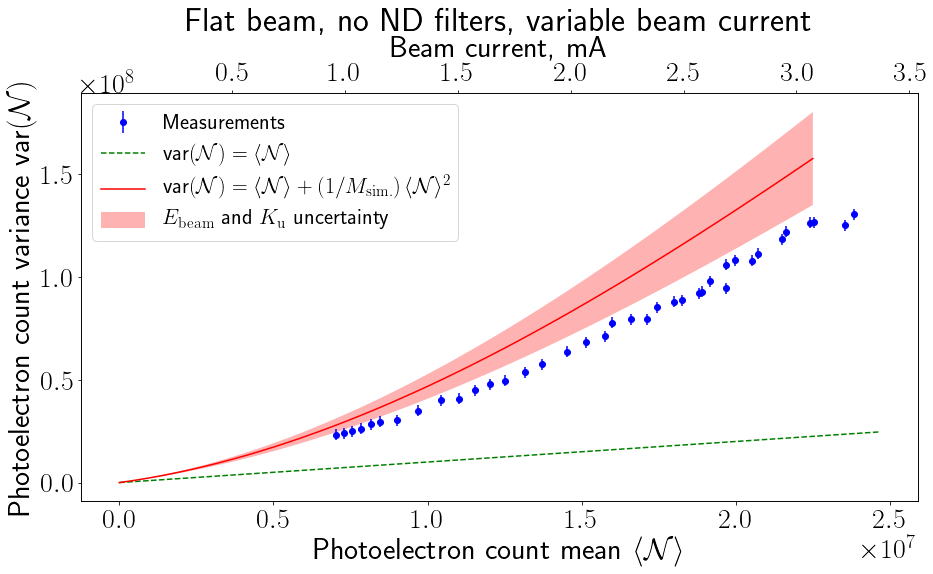

In [13]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots(figsize=(15, 7.5))
res_df_loaded = \
    pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'),
                index_col=0)
res_df_ROUND_no_outliers = res_df_loaded#[res_df_loaded['N']<2.25e7]
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(res_df_ROUND_no_outliers['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
res_df_ROUND_no_outliers['errorbar'] = error_bar
ax.errorbar(res_df_ROUND_no_outliers['N'],res_df_ROUND_no_outliers['varN'],
            marker='o',linestyle='None',yerr=error_bar,color='b',
            label = r'Measurements')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(theor_df['N'], theor_df['varN'], color='red',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}"
        r"\rangle+\left(1/M_{\mathrm{sim.}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom'],
    theor_df['varN_top'],
    facecolor='red', alpha=0.3,
    label=r'$E_{\mathrm{beam}}$ and $K_{\mathrm{u}}$ uncertainty')

ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Flat beam, no ND filters, variable beam current")
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, mA')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[2:-1])
plt.show()